In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import spacy
from matplotlib.pyplot import imread
from wordcloud import WordCloud
%matplotlib inline

In [ ]:
# loading dataset
review = pd.read_csv('Musical_instruments_reviews.csv')

#Data Preprocessing for Sentiment Analysis

In [ ]:
review.shape

(4059, 9)

In [ ]:
review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1.393546e+09,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1.363392e+09,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1.377648e+09,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1.392336e+09,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1.392941e+09,"02 21, 2014"


In [ ]:
# Renaming columns for ease of reference
review = review.rename({'reviewerID':'review_id', 'reviewerName':'review_name', 'reviewText':'review_text', 
               'unixReviewTime':'unix_review_time', 'reviewTime':'review_time'}, axis = 1)
review.head()

,review_id,asin,review_name,helpful,review_text,overall,summary,unix_review_time,review_time
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1.393546e+09,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1.363392e+09,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1.377648e+09,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1.392336e+09,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1.392941e+09,"02 21, 2014"


In [ ]:
# Checking for NA values
review.isna().sum()

review_id            0
asin                 0
review_name         10
helpful              0
review_text          1
overall              1
summary              1
unix_review_time     1
review_time          1
dtype: int64

In [ ]:
review['review_text'] = review['review_text'].fillna('Missing')

In [ ]:
# Concatinating review_text and summary
review['reviews'] = review['review_text'] + review['summary']

# Dropping review_text and summary
review = review.drop(['review_text', 'summary'], axis = 1)
review.head()

,review_id,asin,review_name,helpful,overall,unix_review_time,review_time,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1.393546e+09,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1.363392e+09,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1.377648e+09,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1.392336e+09,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1.392941e+09,"02 21, 2014",This pop filter is great. It looks and perform...


In [ ]:
# Handling review_time column
'''Here we have an unusual review time column which has date and year, once we split both we will split the date 
further into month and date '''

# new data frame which has date and year
new = review["review_time"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
review["date"]= new[0] 
  
# making separate year column from new data frame 
review["year"]= new[1] 

review=review.drop(['review_time'], axis=1)
review.head()

,review_id,asin,review_name,helpful,overall,unix_review_time,reviews,date,year
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1.393546e+09,"Not much to write about here, but it does exac...",02 28,2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1.363392e+09,The product does exactly as it should and is q...,03 16,2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1.377648e+09,The primary job of this device is to block the...,08 28,2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1.392336e+09,Nice windscreen protects my MXL mic and preven...,02 14,2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1.392941e+09,This pop filter is great. It looks and perform...,02 21,2014


In [ ]:
# Splitting the date 
new1 = review["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
review["month"]= new1[0] 
  
# adding day to the main dataset 
review["day"]= new1[1] 

review=review.drop(['date'], axis=1)
review.head()

,review_id,asin,review_name,helpful,overall,unix_review_time,reviews,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1.393546e+09,"Not much to write about here, but it does exac...",2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1.363392e+09,The product does exactly as it should and is q...,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1.377648e+09,The primary job of this device is to block the...,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1.392336e+09,Nice windscreen protects my MXL mic and preven...,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1.392941e+09,This pop filter is great. It looks and perform...,2014,02,21


In [ ]:
# Splitting the dataset based on comma and square bracket 
new1 = review["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)

In [ ]:
helpful

,1,0
0,0,0
1,13,14
2,1,1
3,0,0
4,0,0
...,...,...
4054,2,2
4055,4,4
4056,0,0
4057,2,2


In [ ]:
# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

'''Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those 
#errors'''
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
review['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
review=review.drop(['helpful'], axis=1)

In [ ]:
review['helpful_rate'].value_counts()

0.00    3037
1.00     704
0.50      81
0.67      49
0.75      35
0.80      18
0.33      11
0.92       9
0.60       9
0.88       7
0.94       7
0.90       6
0.93       6
0.89       6
0.25       6
0.95       6
0.78       5
0.83       5
0.96       4
0.86       4
0.97       4
0.98       3
0.71       3
0.85       3
0.62       2
0.81       2
0.58       2
0.73       2
0.09       2
0.76       2
0.82       2
0.87       2
0.40       2
0.46       1
0.91       1
0.70       1
0.79       1
0.29       1
0.44       1
0.07       1
0.11       1
0.30       1
0.12       1
0.22       1
0.10       1
0.65       1
Name: helpful_rate, dtype: int64

#removing the punctuations

In [ ]:
#Removing unnecessary columns
review=review.drop(['review_name','unix_review_time'], axis = 1)
#Creating a copy 
clean_reviews=review.copy()

In [ ]:
import re
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
review['reviews'] = review['reviews'].apply(lambda x: review_cleaning(x))
review.head()

,review_id,asin,overall,reviews,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5.0,not much to write about here but it does exact...,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5.0,the product does exactly as it should and is q...,2013,03,16,0.93
2,A195EZSQDW3E21,1384719342,5.0,the primary job of this device is to block the...,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5.0,nice windscreen protects my mxl mic and preven...,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5.0,this pop filter is great it looks and performs...,2014,02,21,0.00


In [ ]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [ ]:
review['reviews'] = review['reviews'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))
review.head()

,review_id,asin,overall,reviews,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5.0,not much write but exactly supposed filters po...,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5.0,product exactly quite affordablei not realized...,2013,03,16,0.93
2,A195EZSQDW3E21,1384719342,5.0,primary job device block breath would otherwis...,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5.0,nice windscreen protects mxl mic prevents pops...,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5.0,pop filter great looks performs like studio fi...,2014,02,21,0.00


#Calculating sentiment value for reviews

In [ ]:
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [ ]:
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [ ]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [ ]:
#Custom function :score each word in a sentence in lemmatised form, 
#but calculate the score for the whole original sentence.
nlp = spacy.load("en_core_web_sm")
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [ ]:
# test that it works
calculate_sentiment(text = 'nice')

3

In [ ]:
review['sentiment_value'] = review['reviews'].apply(calculate_sentiment)
review

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value
0,A2IBPI20UZIR0U,1384719342,5.0,not much write but exactly supposed filters po...,2014,02,28,0.00,0
1,A14VAT5EAX3D9S,1384719342,5.0,product exactly quite affordablei not realized...,2013,03,16,0.93,3
2,A195EZSQDW3E21,1384719342,5.0,primary job device block breath would otherwis...,2013,08,28,1.00,-1
3,A2C00NNG1ZQQG2,1384719342,5.0,nice windscreen protects mxl mic prevents pops...,2014,02,14,0.00,4
4,A94QU4C90B1AX,1384719342,5.0,pop filter great looks performs like studio fi...,2014,02,21,0.00,5
...,...,...,...,...,...,...,...,...,...
4054,A2LXCPYCPZJVW4,B0009H00WW,5.0,installed ragin cajun fender super champ immed...,2013,12,19,1.00,7
4055,ATB2PLCVQ2XC9,B0009H00WW,5.0,installed ragin cajun fender super champ xd re...,2011,12,1,1.00,20
4056,A1LQC225SE8UNI,B0009H00WW,5.0,fabulous clean tone great distortion sound run...,2014,03,10,0.00,13
4057,A3AZ44SMA0QNW7,B0009H00WW,4.0,installed super champ others pointed youll tur...,2014,03,10,1.00,8


In [ ]:
# how many words are in the sentence?
review['word_count'] = review['reviews'].str.split().apply(len)
review['word_count']

0        25
1        55
2        48
3        22
4        21
       ... 
4054     27
4055    115
4056     26
4057     52
4058      1
Name: word_count, Length: 4059, dtype: int64

In [ ]:
review.sort_values(by='sentiment_value')

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count
957,A8ANJNZAZQ6IQ,B0002D0COE,4.0,thought would throw twocents new design effect...,2014,01,21,1.00,-13,340
2725,A3OZC468867FW8,B0002GZLZQ,4.0,begining wasnt sure buy since lot reviews nega...,2012,12,19,0.00,-12,78
544,A3FW4THIMBIN6V,B0002CZVXM,2.0,disappointed quality engineering product worka...,2011,06,1,0.78,-12,228
2952,AVF06892OWGJU,B0002H0LQO,5.0,annoying thing modern ideas ukulele strings in...,2011,10,26,0.75,-11,45
3970,A3FQ9WYUHG9CD,B0009FUUO2,4.0,if want inexpensive pure nickel string get the...,2011,03,30,1.00,-11,129
...,...,...,...,...,...,...,...,...,...,...
365,A2MMH4O7EDNLCV,B0002CZUUG,5.0,ive playing years currently guitars problem lp...,2012,12,9,0.93,56,346
3613,A3H4S6YO9VNGDZ,B0006H92QK,5.0,ive recording professionally years music radio...,2013,12,26,0.94,57,913
1887,A1QDSJZQWJZOL1,B0002E4Z8M,5.0,need know mic directional must keep mouth swee...,2011,08,11,1.00,63,620
1884,A2KI91IR3RA7D0,B0002E4Z8M,5.0,looking consider best friend voice ever year b...,2012,11,29,1.00,68,621


In [ ]:
# Maximum sentiment value
review['sentiment_value'].max()

144

In [ ]:
# review which is having max sentiment value
review[review['sentiment_value']==139]

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count


In [ ]:
# Full review at index 412
review['reviews'][412]

'greg abrams review entitled but tone snobs review down products pagealright want get good if somewhat basic distortion sound less deali strongly disagree find much better distortions less even near mark currently priced ative played guitar years like many people one first pedal purchases afterall everyone talks theyre available given music store nation hear famous musicians using plus actually pretty cheap snapped one like everyone else come find something popular doesnt always mean good see nickelback transformers movie franchise kardashian family etcso plugged didnt really care distortion harsh thin artificial sounding always noisy tried amps practic amp solid state fender frontman big amp tube halfstack not diverse basic sound not likeable ive read japanese made better sound newer made taiwan models but either way not great pedal mindbut like many newer players didnt know better time fast forward years ive bought sold literally dozens pedals whole world great tones found if keep ey

In [ ]:
# minimum sentiment value
review['sentiment_value'].min()

-13

In [ ]:
# review which is having min sentiment value
review[review['sentiment_value']==-13]

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count
957,A8ANJNZAZQ6IQ,B0002D0COE,4.0,thought would throw twocents new design effect...,2014,01,21,1.0,-13,340


In [ ]:
# Sentiment score of the whole review
review['sentiment_value'].describe()

count    4059.000000
mean        6.406258
std         7.207122
min       -13.000000
25%         2.000000
50%         5.000000
75%         9.000000
max       144.000000
Name: sentiment_value, dtype: float64

In [ ]:
# Sentiment score of the whole review
review[review['sentiment_value']<=0]

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count
0,A2IBPI20UZIR0U,1384719342,5.0,not much write but exactly supposed filters po...,2014,02,28,0.0,0,25
2,A195EZSQDW3E21,1384719342,5.0,primary job device block breath would otherwis...,2013,08,28,1.0,-1,48
7,AJNFQI3YR6XJ5,B00004Y2UT,3.0,use cable run output pedal chain input fender ...,2012,11,16,0.0,0,87
12,A2NIT6BKW11XJQ,B00005ML71,3.0,if not use using large sustaining pedal playin...,2013,11,17,0.0,0,16
28,A2CCGGDGZ694CT,B000068NVI,4.0,hosa xlr cables affordable heavily madei large...,2012,07,11,1.0,-2,29
...,...,...,...,...,...,...,...,...,...,...
4028,A3DCG2MNPR4BW,B0009G1E0K,5.0,really well made straps money problem wished o...,2013,05,22,0.0,-1,10
4030,A3UXW18DP4WSD6,B0009G1E0K,5.0,guitar strap old replaced one didnt want head ...,2014,03,16,0.0,0,12
4036,A2C6Z7M3RMUG45,B0009G1E0K,5.0,strap sturdy looks good goes well fender strat...,2013,04,21,0.0,-2,27
4041,A12P4A1OC41KUO,B0009G1E0K,5.0,price u cant go wrong long enough well made go...,2013,09,1,0.0,-3,18


In [ ]:
review[review['sentiment_value']>=100]

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count
412,A27L5L6I7OSV5B,B0002CZV82,2.0,greg abrams review entitled but tone snobs rev...,2011,06,30,0.95,144,713


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


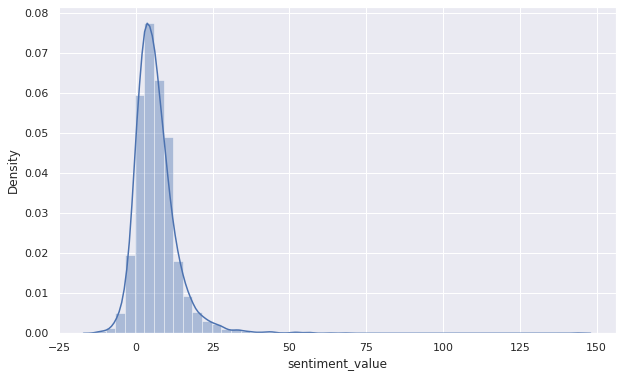

In [ ]:
# Checking the distribution of reviews 

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.distplot(review['sentiment_value'])

In [ ]:
review['index']=range(0,len(review))

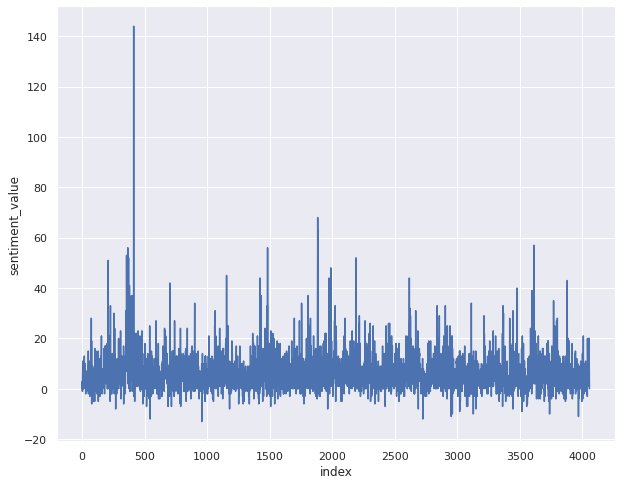

In [ ]:
plt.figure(figsize=(10,8))
sns.lineplot(y='sentiment_value',x='index',data=review)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


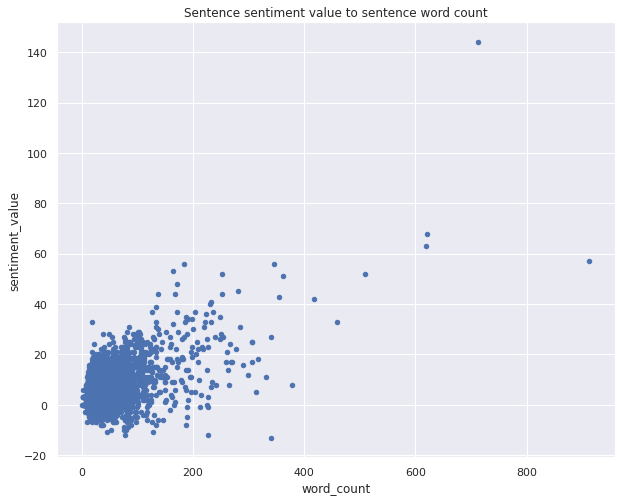

In [ ]:
review.plot.scatter(x='word_count', y='sentiment_value', figsize=(10,8), title='Sentence sentiment value to sentence word count')

In [ ]:
# This function will return sentiment category based on values in sentiment_value column

def sentiment_cat(row):
    
    '''This function returns sentiment category based on values in sentiment_value column'''
    
    if row['sentiment_value'] < 0:
        val = 'Negative'
    elif row['sentiment_value'] == 0: 
        val = 'Neutral'
    elif row['sentiment_value'] > 0:
        val = 'Positive'
    else:
        val = -1
    return val

In [ ]:
#Applying the function in our new column
review['sentiment_category'] = review.apply(sentiment_cat, axis=1)
review.head()

,review_id,asin,overall,reviews,year,month,day,helpful_rate,sentiment_value,word_count,index,sentiment_category
0,A2IBPI20UZIR0U,1384719342,5.0,not much write but exactly supposed filters po...,2014,02,28,0.00,0,25,0,Neutral
1,A14VAT5EAX3D9S,1384719342,5.0,product exactly quite affordablei not realized...,2013,03,16,0.93,3,55,1,Positive
2,A195EZSQDW3E21,1384719342,5.0,primary job device block breath would otherwis...,2013,08,28,1.00,-1,48,2,Negative
3,A2C00NNG1ZQQG2,1384719342,5.0,nice windscreen protects mxl mic prevents pops...,2014,02,14,0.00,4,22,3,Positive
4,A94QU4C90B1AX,1384719342,5.0,pop filter great looks performs like studio fi...,2014,02,21,0.00,5,21,4,Positive


In [ ]:
review['sentiment_category'].value_counts()

Positive    3449
Negative     342
Neutral      268
Name: sentiment_category, dtype: int64

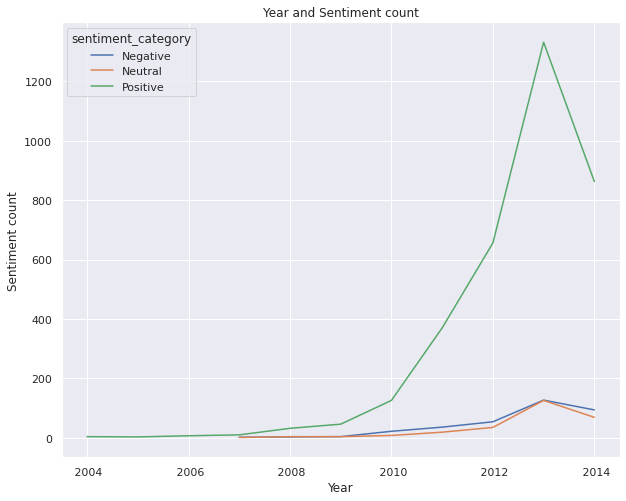

In [ ]:
# Year vs Sentiment count
review.groupby(['year','sentiment_category'])['sentiment_category'].count().unstack().plot(figsize = (10,8),legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

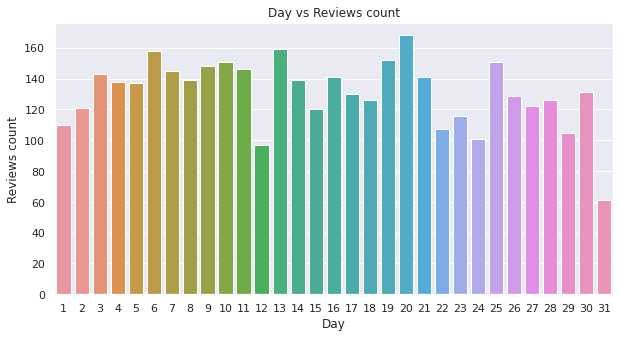

In [ ]:
# Day of month vs Reviews count

#Creating a dataframe
day=pd.DataFrame(review.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.set(rc={'figure.figsize':(10, 5)})
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()